In [4]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps

try:
    # Tworzenie sesji Spark
    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()

    # Parametry połączenia z bazą danych MSSQL
    server_name = "mssql-server"
    port = "1433"
    database_name = "ETLKI"
    url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

    table_name = "ETLKI"
    username = "sa"
    password = "YourStrongPassword123"

    # Wczytanie danych z bazy danych MSSQL
    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

    print("Dane zostały pomyślnie wczytane z MSSQL.")
    # Wyświetlenie pierwszych kilku wierszy DataFrame
    df.show(5)

except Exception as e:
    print("Wystąpił błąd podczas łączenia z bazą danych:", str(e))



Dane zostały pomyślnie wczytane z MSSQL.
+----------+---------+----------+----------+--------+----+----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+--------+--------------------+------------+-------+---------+------------------+-------------------+----------+---------------------------+---------------+-------------------+----------------+--------------------+---------------+-------------+----+-----+---+----+-------+-----------+---------------+
|Unnamed: 0|    DR_NO| Date Rptd|  DATE OCC|TIME OCC|AREA| AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|      Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|gender of criminal|c

In [5]:
df.columns

['Unnamed: 0',
 'DR_NO',
 'Date Rptd',
 'DATE OCC',
 'TIME OCC',
 'AREA',
 'AREA NAME',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Crm Cd Desc',
 'Mocodes',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON',
 'gender of criminal',
 'country of criminal',
 'kill count',
 'marital status of criminal ',
 'age of criminal',
 'previously punished',
 'education levels',
 'drug substances',
 'annual earnings',
 'value_divided',
 'Time',
 'Month',
 'Day',
 'Year',
 'Quarter',
 'Day of Week',
 'Vict Age bucket']

## Data Mining

### 1. Przewidywanie ilości zabitych dziennie w ciągu następnego roku

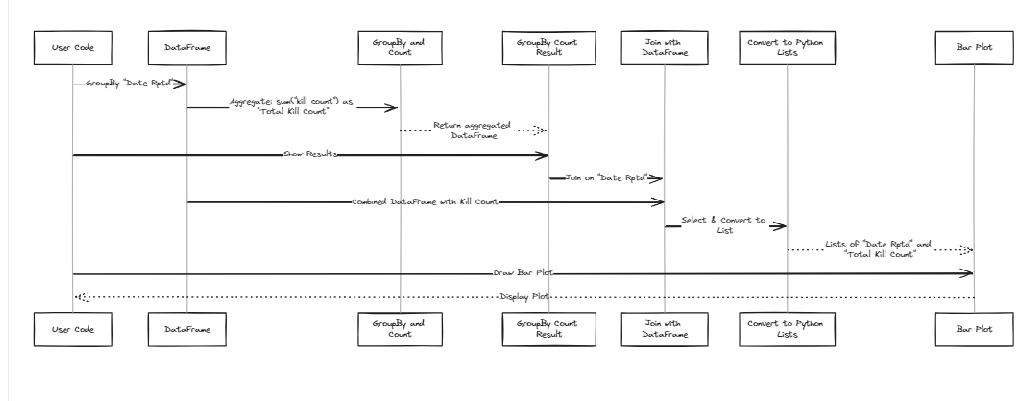

In [222]:
from IPython.display import Image
Image(filename='mining1.png')

+----------+----------------+
| Date Rptd|Total Kill Count|
+----------+----------------+
|2021-12-18|              10|
|2022-08-02|              10|
|2022-12-25|              12|
|2022-07-27|               0|
|2022-11-29|              16|
|2020-08-29|              14|
|2023-06-18|               4|
|2021-04-29|               0|
|2022-01-29|               2|
|2022-05-26|               0|
|2020-03-07|               0|
|2021-07-17|               0|
|2023-06-23|               0|
|2020-02-15|               0|
|2021-09-11|               0|
|2022-07-07|               0|
|2021-02-15|               0|
|2022-12-09|               6|
|2022-04-02|               2|
|2022-03-12|               4|
+----------+----------------+
only showing top 20 rows



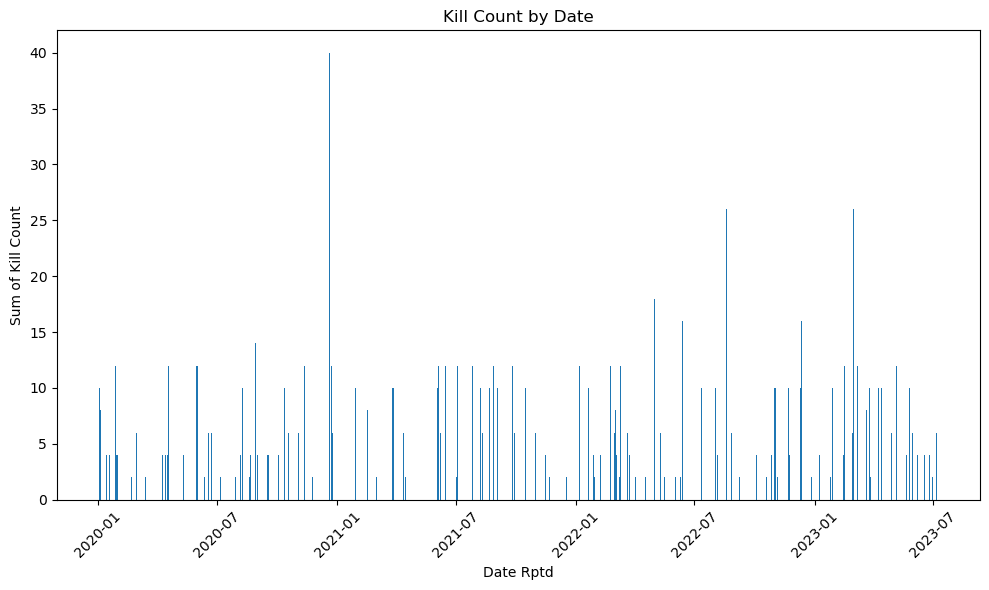

In [206]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum

# Grupowanie danych i zliczanie kill count w danej dacie
kill_count_by_date = df.groupBy("Date Rptd").agg(sum("kill count").alias("Total Kill Count"))

# Wyświetlenie wyników
kill_count_by_date.show()

# Połączenie wyników z oryginalną ramką danych
df_with_kill_count = df.join(kill_count_by_date, "Date Rptd", "left")

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Wykres słupkowy
plt.figure(figsize=(10, 6))
plt.bar(date_rptd, kill_count)
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Importowanie bibliotek: Importujemy potrzebne biblioteki, w tym NumPy, Matplotlib, Pandas oraz XGBoost. Te biblioteki są używane do manipulacji danych, tworzenia modelu regresji oraz wizualizacji wyników.
Utworzenie ramki danych: Tworzymy ramkę danych Pandas, zawierającą daty zgłoszeń (Date Rptd) i sumę liczby zabitych (Sum of Kill Count).
Uzupełnienie brakujących dat: Sprawdzamy, czy dane obejmują pełny zakres dat. Jeśli nie, uzupełniamy brakujące daty zerowymi wartościami liczby zabitych.
Przygotowanie danych do modelu XGBoost: Tworzymy zmienne objaśniające (X) i zmienną objaśnianą (y). W tym przypadku, używamy miesiąca i dnia jako cech do przewidywania liczby zabitych.
Podział danych na zbiór treningowy i testowy: Dzielimy dane na zbiór treningowy i testowy w celu oceny wydajności modelu.
Dopasowanie modelu XGBoost: Tworzymy model regresji XGBoost i dopasowujemy go do danych treningowych.
Prognoza na kolejny rok: Przygotowujemy dane na kolejny rok i przewidujemy liczbę zabitych za pomocą wytrenowanego modelu.

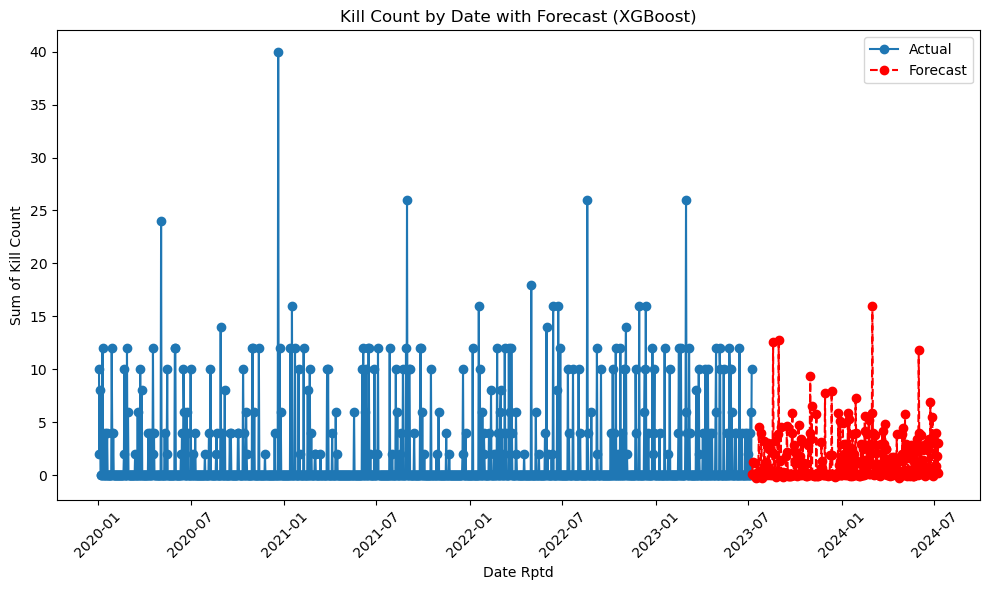

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu XGBoost
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu XGBoost
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast (XGBoost)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 2. Tworzenie przewidywania ilości przestępstw popełnionych na kobietach przez latynoskiego pochodzenia mężczyzn w przedziale wiekowym 18-35

In [210]:
# Przefiltrowanie danych
df_filtered1 = df.filter(
    (col("gender of criminal") == "m") &
    (col("Vict Sex") == "Female") &
    (col("Vict Descent") == "Hispanic or Latino") &
    (col("age of criminal") == "18-35") 
)
count_by_date = df_filtered1.groupBy("Date Rptd").count()

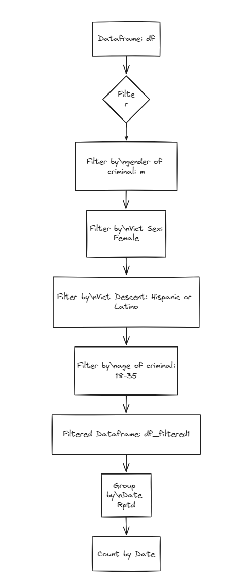

In [223]:
from IPython.display import Image
Image(filename='mining2.png')

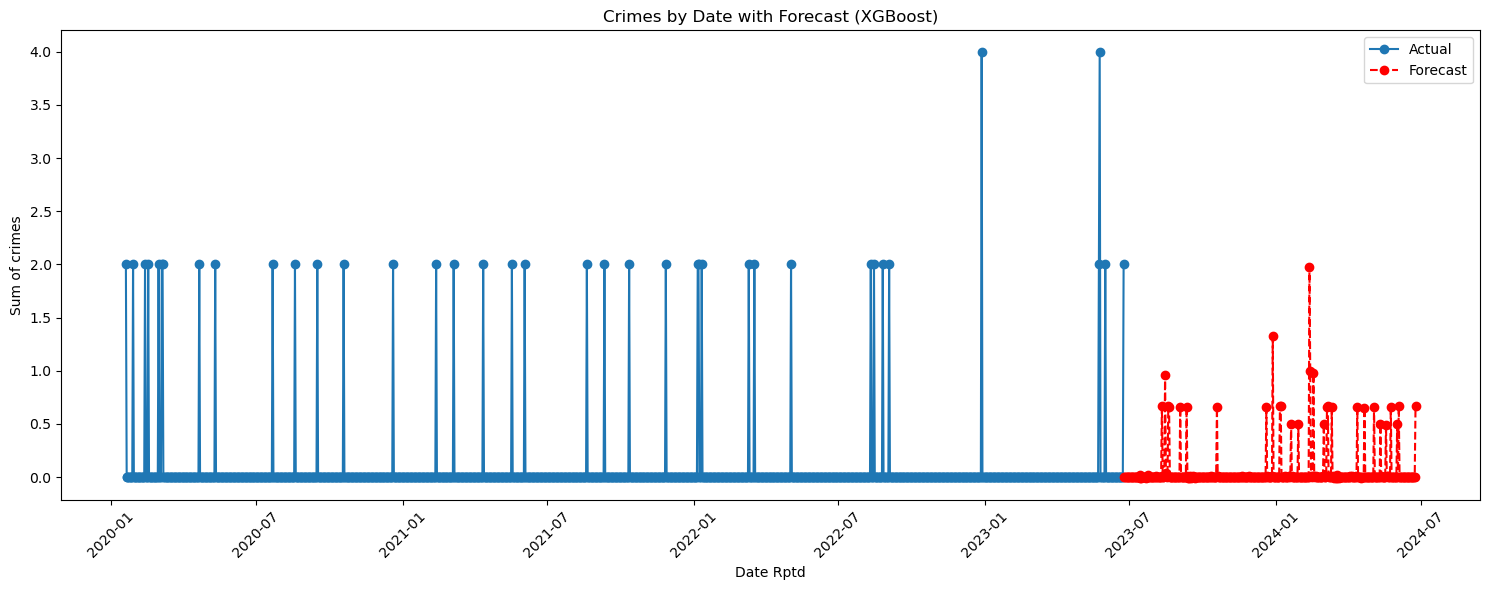

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Konwersja danych do list Pythona
date_rptd_1 = count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
crime_count_1 = count_by_date.select("count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd_1, 'Sum of Kill Count': crime_count_1})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu XGBoost
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą (szerszy)
plt.figure(figsize=(15, 6))  # Zmiana szerokości na 15 cali
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of crimes')
plt.title('Crimes by Date with Forecast (XGBoost)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 3. Będziemy chcieli przewidzień ile będzie przestępstw w poszczególnych miesiącach następnego roku popełnionych przez osoby bez wyższego wykształcenia, które biorą mocne narkotyki oraz ofiary zarabiają powyżej 100000$.

In [ ]:
# Przefiltrowanie danych
df_filtered2 = df.filter(
    (col("AREA NAME") == "Hollywood") &
    (col("education levels") != "Higher education") &
    (col("drug substances") != "Alcohol") &
    (col("annual earnings") >= 100000) 
)
count_by_date2 = df_filtered2.groupBy("Date Rptd").count()

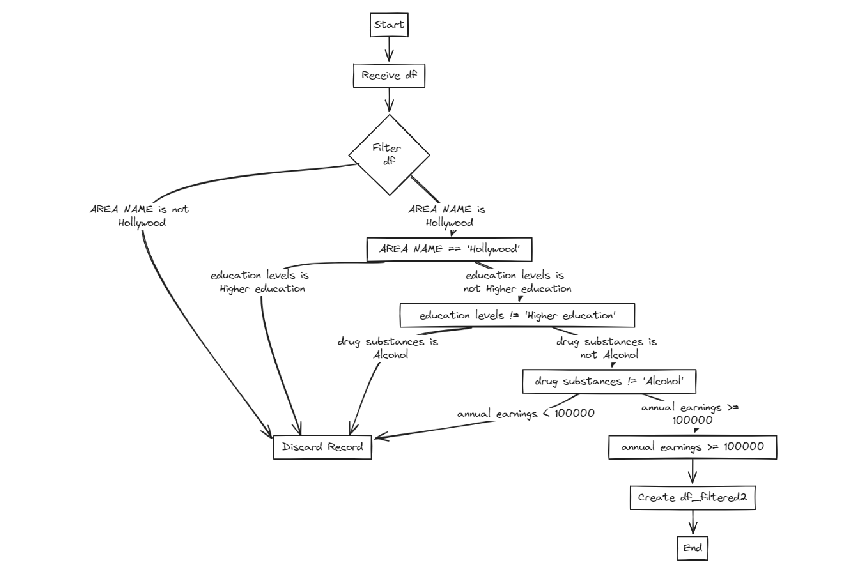

In [226]:
from IPython.display import Image
Image(filename='KPI2.png')

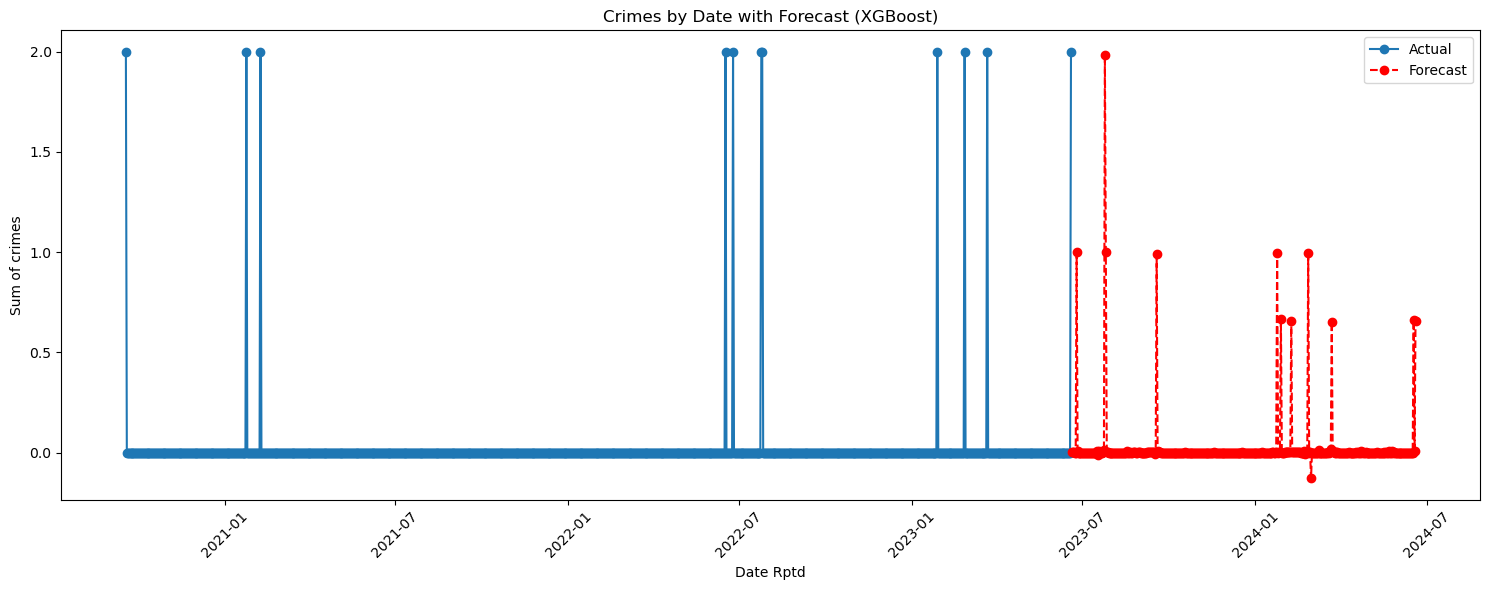

In [212]:
date_rptd_2 = count_by_date2.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
crime_count_2 = count_by_date2.select("count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd_2, 'Sum of crimes': crime_count_2})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of crimes': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu XGBoost
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of crimes']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą (szerszy)
plt.figure(figsize=(15, 6))
plt.plot(df['Date Rptd'], df['Sum of crimes'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of crimes')
plt.title('Crimes by Date with Forecast (XGBoost)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [229]:
df.columns

['Unnamed: 0',
 'DR_NO',
 'Date Rptd',
 'DATE OCC',
 'TIME OCC',
 'AREA',
 'AREA NAME',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Crm Cd Desc',
 'Mocodes',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON',
 'gender of criminal',
 'country of criminal',
 'kill count',
 'marital status of criminal ',
 'age of criminal',
 'previously punished',
 'education levels',
 'drug substances',
 'annual earnings']

In [230]:
df.show()

+----------+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+------------------+-------------------+----------+---------------------------+---------------+-------------------+----------------+--------------------+---------------+
|Unnamed: 0|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|gender of criminal|country of criminal|kill count|marital status of criminal |age o

### 4. Przewidywanie średnich dziennych zarobów okradzinych osób w ciągu następnego roku 